In [19]:
# Load modules
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph
import plotly.graph_objects as go
import plotly.express as px
import re
#! pip install -U kaleido
#! pip install psutil

# setup some pandas display modes
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_colwidth", None)

%matplotlib inline

## Load the data frame

In [20]:
# Read query results from CSV file
get_ratio_df_all_per_global = pd.read_csv("get_ratio_df_all_per_global1.csv")

# drop first column
get_ratio_df_all_per_global = get_ratio_df_all_per_global.drop(["Unnamed: 0"], axis=1)


# change the column to name the facets of the plot
get_ratio_df_all_per_global = get_ratio_df_all_per_global.rename(
    columns={"merge": "metricName"}
)
get_ratio_df_all_per_global["metricName"] = get_ratio_df_all_per_global[
    "metricName"
].str.replace("\\", "")

get_ratio_df_all_per_global["unique_ds"] = (
    get_ratio_df_all_per_global["ds"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)
get_ratio_df_all_per_global["unique_task"] = (
    get_ratio_df_all_per_global["task"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)

get_ratio_df_all_per_global["unique_task_ds_metric"] = (
    get_ratio_df_all_per_global["task"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["ds"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)

# plot unique metricName
pd.DataFrame(get_ratio_df_all_per_global["metricName"].unique())

<ipython-input-20-2e5f5b796e0a>:12: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



,0
0,1 in 10 R-at-1
1,F1
...,...
174,DE
175,BA


## Prepare the data frame

In [21]:
#calculate average data frame using 'RATIO' as criteria FOR unique_task
#This graph is fine, however, it will display overlapped datasets used for the same task in the same trajectory.
traj = get_ratio_df_all_per_global.copy()

#task causing some problems
traj = traj.drop(traj[traj["metricName"]=="Parameters"].index)
#traj = traj.drop(traj[traj["unique_task"]=="Natural Language Inference, Parameters"].index)

#Process date field
#traj["date"]=pd.to_datetime(traj["date"]).dt.year

#traj["date"] = pd.to_datetime(traj["date"]).dt.strftime('%Y-%m')


In [22]:
# This will drop cases where the single points that represents ratio = 100%.
# traj = traj.drop(traj[traj["ratio"]==1].index)

In [23]:
# this will delete from the traj data frame, all the ds/tasks which the counts are equal to 1
# pd.set_option("display.max_rows", None)
count_df = pd.DataFrame(traj["ds"].value_counts())
count_df[count_df.ds == 1].index
# the symbol ~ selects reverse to .isin
traj = traj[~traj["ds"].isin(count_df[count_df.ds == 1].index)]

count_df = pd.DataFrame(traj["task"].value_counts())
count_df[count_df.task == 1].index

traj = traj[~traj["task"].isin(count_df[count_df.task == 1].index)]
pd.DataFrame(traj["ds"].value_counts())

,ds
CNN / Daily Mail,47
SemEval 2014 Task 4 Sub Task 2,33
...,...
TREC-PM,1
WebQSP-WD,1


## Plot using Ratio for Task

In [24]:
# this function is declared to add the anchor dots (white dots) to the trajectory
def add_white(category):
    fig.add_trace(
        go.Scatter(
            x=average_summary_OUT["date"],
            y=average_summary_OUT[category],
            mode="markers",
            name=None,
            marker=dict(
                size=10,
                color="white",
                # opacity=0.5,
            ),
            hovertemplate=average_summary_OUT[category]
            + "<BR>category: "
            + average_summary_OUT[category]
            + "<BR>date: "
            + average_summary_OUT["date"].astype("string")
            + "<BR>ratio: "
            + average_summary_OUT["ratio"].astype("string"),
        )
    )

### Plot with anchor and at east two points per trajectory

In [25]:
# variable_to_plot = "ratio"
# choose here which grouping variable to use
average_summary = pd.DataFrame(traj.groupby(["task", "date"])["ratio"].mean())

# DROP anchors
# average_summary = average_summary.drop(average_summary[average_summary["ratio"]>0.5].index)


average_summary.sort_values(by=["date"], ascending=True)

average_summary.reset_index(inplace=True)
# average_summary["date"]=pd.to_datetime(average_summary['date'])
# average_summary["date"]=average_summary["date"].dt.year
average_summary["in_trajectory"] = 1


i = 0
for t in average_summary.task.unique():
    sota_per = 0
    # here the date can't be unique, because we want to look for the best value per year
    for v in average_summary[average_summary["task"] == t].ratio:
        per = average_summary[
            (average_summary["task"] == t) & (average_summary["ratio"] == v)
        ].ratio.astype(float)
        per = per.iloc[0]
        if per >= sota_per:
            # print(per)
            sota_per = per
            average_summary.loc[i, "in_trajectory"] = "IN"
        else:
            # average_summary = average_summary.drop(i)
            average_summary.loc[i, "in_trajectory"] = "IN"  # change back to OUT
            # sota_per = per
        i = i + 1

# Add OUT to high gain values, normally those of the first results. They will be displayed as white dots.

# NOTE
# Ignore this for heatmap
average_summary.loc[average_summary["ratio"] > 0.5, "in_trajectory"] = "OUT"

average_summary["ratio"] = average_summary["ratio"].apply(lambda x: round(x, 2))
# average_summary = average_summary.rename(columns={'gain': 'gain'})

# needs to rename here to average of percentage of maximum sota


###NOW PLOT IT
# try using plotly
import pandas as pd
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator

average_summary_IN = average_summary[average_summary["in_trajectory"] == "IN"]
average_summary_OUT = average_summary[average_summary["in_trajectory"] == "OUT"]

fig = px.line(average_summary_IN, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

add_white("task")

fig.add_trace(
    go.Scatter(
        x=average_summary_IN["date"],
        y=average_summary_IN["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN["task"]
        + "<BR>task: "
        + average_summary_IN["task"]
        + "<BR>date: "
        + average_summary_IN["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig.update_layout(
    #title="Trajectory for ratio (task per year)",
    title_text='Trajectory for ratio (task per year).<BR><BR>Anchor points (ratio>0.5) as white circles, trajectories with single arrow displayed.',
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)
fig.show()

In [26]:
# This shows the points that will be added as arrows to the graph: IN
average_summary.head()

,task,date,ratio,in_trajectory
0,Abstractive Text Summarization,2017-04,0.84,OUT
1,Abstractive Text Summarization,2019-05,0.40,IN
2,Abstractive Text Summarization,2019-12,0.03,IN
3,Abstractive Text Summarization,2020-01,0.01,IN
4,Ad-Hoc Information Retrieval,2017-04,0.87,OUT


In [27]:
# This block will take the values from average_summary_IN and delete those that have only one arrow per trajectory
count_df = pd.DataFrame(average_summary_IN["task"].value_counts())
count_df[count_df.task == 1].index
average_summary_IN = average_summary_IN[
    ~average_summary_IN["task"].isin(count_df[count_df.task == 1].index)
]
# this will delete from the traj data frame, all the tasks which the average_summary_IN counts are equal to 1
# meaning single arrows will be excluded from the plot

### Same plot as before, but then, only with more than one arrow per trajectory.

In [28]:
fig_traj = px.line(average_summary_IN, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
# add_white("task")

fig_traj.add_trace(
    go.Scatter(
        x=average_summary_IN["date"],
        y=average_summary_IN["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN["task"]
        + "<BR>task: "
        + average_summary_IN["task"]
        + "<BR>date: "
        + average_summary_IN["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj.update_layout(
    #title="Trajectory for ratio (task per year)",
    title_text='Trajectory for ratio (task per year).<BR><BR>Anchor points (ratio>0.5) removed, trajectories with single arrow removed.',
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj.show()

In [29]:
#This sets cose to zero values equal to 0.001 in the trajectory.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

average_summary_IN.loc[(average_summary_IN['ratio'] == 0), "ratio"] = 0.001

average_summary_IN

,task,date,ratio,in_trajectory
1,Abstractive Text Summarization,2019-05,0.400,IN
2,Abstractive Text Summarization,2019-12,0.030,IN
3,Abstractive Text Summarization,2020-01,0.010,IN
6,Ad-Hoc Information Retrieval,2018-09,0.001,IN
7,Ad-Hoc Information Retrieval,2018-10,0.001,IN
8,Ad-Hoc Information Retrieval,2018-12,0.001,IN
9,Ad-Hoc Information Retrieval,2019-03,0.001,IN
10,Ad-Hoc Information Retrieval,2019-04,0.100,IN
13,Aspect-Based Sentiment Analysis,2016-05,0.050,IN
15,Aspect-Based Sentiment Analysis,2017-09,0.020,IN


In [30]:
average_summary_IN.loc[(average_summary_IN['ratio'] == 0), "ratio"] = 0.001

# CLUSTERING

In [31]:
#Input of the clustering step: no anchors and no single point trajectory
average_summary_IN.head(5)

,task,date,ratio,in_trajectory
1,Abstractive Text Summarization,2019-05,0.400,IN
2,Abstractive Text Summarization,2019-12,0.030,IN
3,Abstractive Text Summarization,2020-01,0.010,IN
6,Ad-Hoc Information Retrieval,2018-09,0.001,IN
7,Ad-Hoc Information Retrieval,2018-10,0.001,IN


In [32]:
#melt the data frame to prepare data
df_melted = pd.melt(average_summary_IN, id_vars=["task", "date"], value_vars=["ratio"])

#set numeric column to float
df_melted["value"] = df_melted["value"].astype(float)

#this sets the DS as leaves for the  clustering entities
df=pd.DataFrame(columns=df_melted["date"].unique())

df["task"]=df_melted["task"].unique()

df=df.set_index("task")


#fill the clustering df
#create this data frame to use for clustering, fill variables that are not available with 0
#df_melted["value"] = df_melted["value"].astype(float)
for ds in df_melted["task"].unique():
    for var in df_melted["date"].unique():
    #print(ds)
        value = df_melted[(df_melted["task"]==ds)&(df_melted["date"]==var)]["value"]
        if(len(value)>0):
            print(ds,"\t",var,"\t",value.iloc[0])
            df.loc[ds,var] = value.iloc[0]
            #df = df.append(pd.Series({var: value}, name=ds))
        else:
            print(ds,"\t",var,"\t0",)
            #df(ds)[var] = "NaN"
            #df = df.append(pd.Series({var: "NaN"}, name=ds))   


Abstractive Text Summarization 	 2019-05 	 0.4
Abstractive Text Summarization 	 2019-12 	 0.03
Abstractive Text Summarization 	 2020-01 	 0.01
Abstractive Text Summarization 	 2018-09 	0
Abstractive Text Summarization 	 2018-10 	0
Abstractive Text Summarization 	 2018-12 	0
Abstractive Text Summarization 	 2019-03 	0
Abstractive Text Summarization 	 2019-04 	0
Abstractive Text Summarization 	 2016-05 	0
Abstractive Text Summarization 	 2017-09 	0
Abstractive Text Summarization 	 2018-02 	0
Abstractive Text Summarization 	 2018-04 	0
Abstractive Text Summarization 	 2018-05 	0
Abstractive Text Summarization 	 2018-06 	0
Abstractive Text Summarization 	 2019-02 	0
Abstractive Text Summarization 	 2019-06 	0
Abstractive Text Summarization 	 2019-08 	0
Abstractive Text Summarization 	 2020-04 	0
Abstractive Text Summarization 	 2019-07 	0
Abstractive Text Summarization 	 2019-10 	0
Abstractive Text Summarization 	 2019-11 	0
Abstractive Text Summarization 	 2016-11 	0
Abstractive Text Summ

Citation Intent Classification 	 2018-04 	0
Citation Intent Classification 	 2018-05 	0
Citation Intent Classification 	 2018-06 	0
Citation Intent Classification 	 2019-02 	0
Citation Intent Classification 	 2019-06 	0
Citation Intent Classification 	 2019-08 	0
Citation Intent Classification 	 2020-04 	0
Citation Intent Classification 	 2019-07 	0
Citation Intent Classification 	 2019-10 	0
Citation Intent Classification 	 2019-11 	0
Citation Intent Classification 	 2016-11 	0
Citation Intent Classification 	 2018-08 	0
Citation Intent Classification 	 2016-06 	 0.16
Citation Intent Classification 	 2018-01 	 0.48
Citation Intent Classification 	 2017-01 	0
Citation Intent Classification 	 2017-07 	0
Citation Intent Classification 	 2019-01 	0
Citation Intent Classification 	 2016-09 	0
Citation Intent Classification 	 2018-11 	0
Citation Intent Classification 	 2014-04 	0
Citation Intent Classification 	 2014-12 	0
Citation Intent Classification 	 2019-09 	0
Citation Intent Classifi

Cross-Lingual Bitext Mining 	 2015-04 	0
Cross-Lingual Document Classification 	 2019-05 	0
Cross-Lingual Document Classification 	 2019-12 	0
Cross-Lingual Document Classification 	 2020-01 	0
Cross-Lingual Document Classification 	 2018-09 	0
Cross-Lingual Document Classification 	 2018-10 	0
Cross-Lingual Document Classification 	 2018-12 	 0.04
Cross-Lingual Document Classification 	 2019-03 	0
Cross-Lingual Document Classification 	 2019-04 	0
Cross-Lingual Document Classification 	 2016-05 	0
Cross-Lingual Document Classification 	 2017-09 	0
Cross-Lingual Document Classification 	 2018-02 	0
Cross-Lingual Document Classification 	 2018-04 	0
Cross-Lingual Document Classification 	 2018-05 	0
Cross-Lingual Document Classification 	 2018-06 	0
Cross-Lingual Document Classification 	 2019-02 	0
Cross-Lingual Document Classification 	 2019-06 	0
Cross-Lingual Document Classification 	 2019-08 	0
Cross-Lingual Document Classification 	 2020-04 	0
Cross-Lingual Document Classification

Document Classification 	 2016-03 	 0.1
Document Classification 	 2018-07 	0
Document Classification 	 2017-11 	0
Document Classification 	 2017-10 	 0.02
Document Classification 	 2017-05 	0
Document Classification 	 2017-12 	0
Document Classification 	 2017-04 	0
Document Classification 	 2016-07 	0
Document Classification 	 2017-08 	0
Document Classification 	 2020-02 	0
Document Classification 	 2014-09 	0
Document Classification 	 2014-10 	0
Document Classification 	 2016-08 	0
Document Classification 	 2016-10 	0
Document Classification 	 2017-06 	0
Document Classification 	 2014-08 	0
Document Classification 	 2017-02 	0
Document Classification 	 2017-03 	0
Document Classification 	 2015-08 	0
Document Classification 	 2014-06 	0
Document Classification 	 2015-06 	0
Document Classification 	 2015-11 	0
Document Classification 	 2016-02 	0
Document Classification 	 2016-01 	0
Document Classification 	 2020-03 	0
Document Classification 	 2015-02 	0
Document Classification 	 2015-

Joint Entity and Relation Extraction 	 2016-05 	0
Joint Entity and Relation Extraction 	 2017-09 	0
Joint Entity and Relation Extraction 	 2018-02 	0
Joint Entity and Relation Extraction 	 2018-04 	0
Joint Entity and Relation Extraction 	 2018-05 	0
Joint Entity and Relation Extraction 	 2018-06 	0
Joint Entity and Relation Extraction 	 2019-02 	0
Joint Entity and Relation Extraction 	 2019-06 	0
Joint Entity and Relation Extraction 	 2019-08 	0
Joint Entity and Relation Extraction 	 2020-04 	0
Joint Entity and Relation Extraction 	 2019-07 	0
Joint Entity and Relation Extraction 	 2019-10 	0
Joint Entity and Relation Extraction 	 2019-11 	0
Joint Entity and Relation Extraction 	 2016-11 	0
Joint Entity and Relation Extraction 	 2018-08 	0
Joint Entity and Relation Extraction 	 2016-06 	0
Joint Entity and Relation Extraction 	 2018-01 	0
Joint Entity and Relation Extraction 	 2017-01 	0
Joint Entity and Relation Extraction 	 2017-07 	0
Joint Entity and Relation Extraction 	 2019-01 	0


Named Entity Recognition 	 2015-02 	0
Named Entity Recognition 	 2015-04 	0
Natural Language Inference 	 2019-05 	0
Natural Language Inference 	 2019-12 	0
Natural Language Inference 	 2020-01 	0
Natural Language Inference 	 2018-09 	 0.42
Natural Language Inference 	 2018-10 	 0.06
Natural Language Inference 	 2018-12 	 0.35
Natural Language Inference 	 2019-03 	0
Natural Language Inference 	 2019-04 	0
Natural Language Inference 	 2016-05 	0
Natural Language Inference 	 2017-09 	 0.001
Natural Language Inference 	 2018-02 	0
Natural Language Inference 	 2018-04 	 0.01
Natural Language Inference 	 2018-05 	 0.01
Natural Language Inference 	 2018-06 	0
Natural Language Inference 	 2019-02 	0
Natural Language Inference 	 2019-06 	 0.09
Natural Language Inference 	 2019-08 	0
Natural Language Inference 	 2020-04 	0
Natural Language Inference 	 2019-07 	 0.19
Natural Language Inference 	 2019-10 	 0.02
Natural Language Inference 	 2019-11 	 0.01
Natural Language Inference 	 2016-11 	0
Nat

Paraphrase Identification 	 2016-09 	0
Paraphrase Identification 	 2018-11 	0
Paraphrase Identification 	 2014-04 	0
Paraphrase Identification 	 2014-12 	0
Paraphrase Identification 	 2019-09 	0
Paraphrase Identification 	 2018-03 	0
Paraphrase Identification 	 2016-03 	0
Paraphrase Identification 	 2018-07 	0
Paraphrase Identification 	 2017-11 	0
Paraphrase Identification 	 2017-10 	0
Paraphrase Identification 	 2017-05 	0
Paraphrase Identification 	 2017-12 	0
Paraphrase Identification 	 2017-04 	 0.001
Paraphrase Identification 	 2016-07 	0
Paraphrase Identification 	 2017-08 	0
Paraphrase Identification 	 2020-02 	0
Paraphrase Identification 	 2014-09 	0
Paraphrase Identification 	 2014-10 	0
Paraphrase Identification 	 2016-08 	0
Paraphrase Identification 	 2016-10 	0
Paraphrase Identification 	 2017-06 	0
Paraphrase Identification 	 2014-08 	0
Paraphrase Identification 	 2017-02 	0
Paraphrase Identification 	 2017-03 	0
Paraphrase Identification 	 2015-08 	0
Paraphrase Identific

Semantic Role Labeling 	 2018-04 	0
Semantic Role Labeling 	 2018-05 	0
Semantic Role Labeling 	 2018-06 	0
Semantic Role Labeling 	 2019-02 	0
Semantic Role Labeling 	 2019-06 	0
Semantic Role Labeling 	 2019-08 	0
Semantic Role Labeling 	 2020-04 	0
Semantic Role Labeling 	 2019-07 	0
Semantic Role Labeling 	 2019-10 	0
Semantic Role Labeling 	 2019-11 	0
Semantic Role Labeling 	 2016-11 	0
Semantic Role Labeling 	 2018-08 	0
Semantic Role Labeling 	 2016-06 	0
Semantic Role Labeling 	 2018-01 	0
Semantic Role Labeling 	 2017-01 	0
Semantic Role Labeling 	 2017-07 	0
Semantic Role Labeling 	 2019-01 	0
Semantic Role Labeling 	 2016-09 	0
Semantic Role Labeling 	 2018-11 	0
Semantic Role Labeling 	 2014-04 	0
Semantic Role Labeling 	 2014-12 	0
Semantic Role Labeling 	 2019-09 	0
Semantic Role Labeling 	 2018-03 	0
Semantic Role Labeling 	 2016-03 	0
Semantic Role Labeling 	 2018-07 	 0.01
Semantic Role Labeling 	 2017-11 	0
Semantic Role Labeling 	 2017-10 	0
Semantic Role Labeling 	

Text Classification 	 2017-10 	0
Text Classification 	 2017-05 	0
Text Classification 	 2017-12 	0
Text Classification 	 2017-04 	0
Text Classification 	 2016-07 	0
Text Classification 	 2017-08 	0
Text Classification 	 2020-02 	0
Text Classification 	 2014-09 	0
Text Classification 	 2014-10 	0
Text Classification 	 2016-08 	0
Text Classification 	 2016-10 	0
Text Classification 	 2017-06 	0
Text Classification 	 2014-08 	0
Text Classification 	 2017-02 	 0.17
Text Classification 	 2017-03 	0
Text Classification 	 2015-08 	0
Text Classification 	 2014-06 	0
Text Classification 	 2015-06 	0
Text Classification 	 2015-11 	 0.15
Text Classification 	 2016-02 	0
Text Classification 	 2016-01 	0
Text Classification 	 2020-03 	0
Text Classification 	 2015-02 	0
Text Classification 	 2015-04 	 0.42
Text Generation 	 2019-05 	0
Text Generation 	 2019-12 	0
Text Generation 	 2020-01 	0
Text Generation 	 2018-09 	0
Text Generation 	 2018-10 	0
Text Generation 	 2018-12 	0
Text Generation 	 2019

In [33]:
# fill missing values with 0, this represents metrics that have not been collected for a benchmark
df = df.fillna(0)

In [34]:
#check the report df, all date columns have to have at least one value. 
report = pd.DataFrame(df.describe().T)
report = report.sort_values(by="count", ascending=False)
report[report["max"]==0]["max"].count()

0

In [35]:
#get here the top (unique>10) variables to use for the HC 
#Obs: in this case if we use the task as clustering entities, then it doesn't make sense to filter. Just use every thing
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

#select variables that have been colected at least by 10 benchmarks
#when using tasks for clustering, keep it >0
unique_vars = list(report[report["count"]>0].index.unique())

#create input_hc for those selected variable (date)
input_hc = df[df.columns.intersection(unique_vars)]


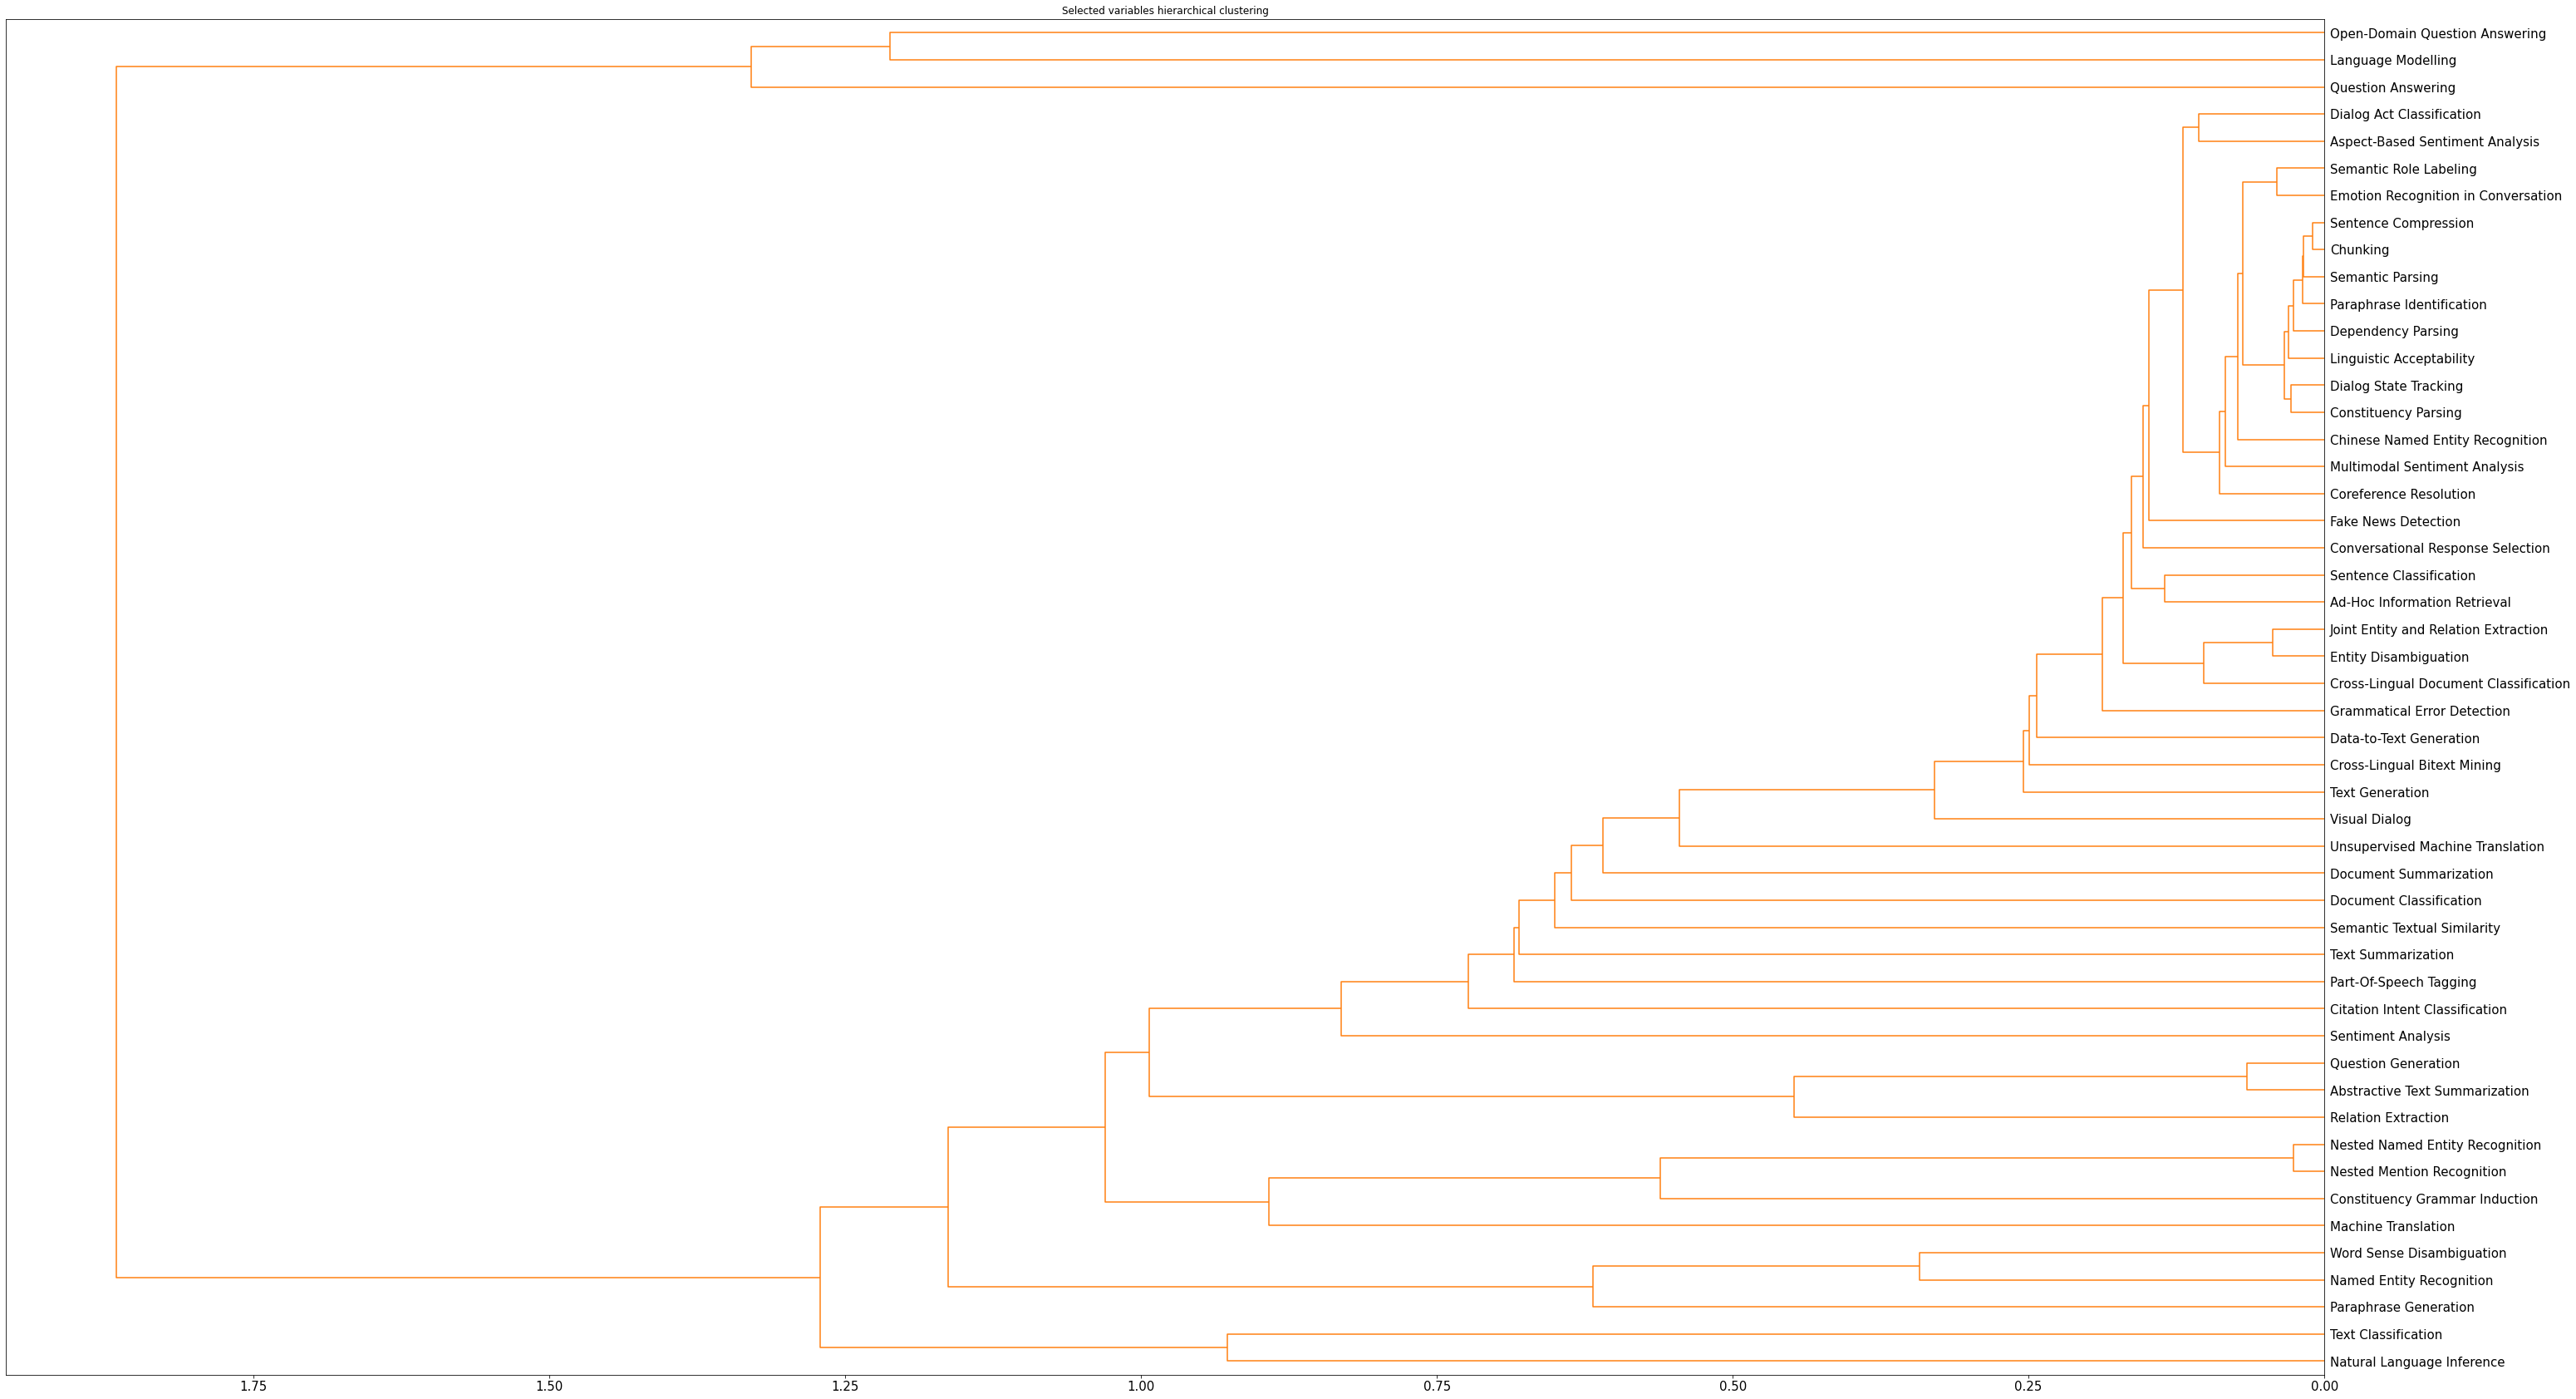

In [37]:
import scipy.cluster.hierarchy as shc

# col_filter="Accuracy,"
# col_filter="F1,|Accuracy,|BLEU,|Recall,|Precision,|BLEU score,"

plt.figure(figsize=(50, 30))
plt.title("Selected variables hierarchical clustering")

# cut=400 #for value

cut = 2.5  # for percentage

# define inside the regular expression which variable to use for the clustering (unique_vars variable)
dend = shc.dendrogram(
    shc.linkage(np.array(input_hc), method="ward"),
    labels=df.index,
    orientation="left",
    color_threshold=cut,
)
ax = plt.gca()
ax.tick_params(axis="x", which="major", labelsize=15)
ax.tick_params(axis="y", which="major", labelsize=15)
plt.axvline(linestyle="--", x=cut, c="Blue")

# plt.savefig('dend_percent_max_sota.png')
# plt.savefig('dend_percent.png')
# plt.savefig('dend_value.png')
plt.savefig("./PLOT_4_plots/dend_ratio_unique_task.png")


# Ref:https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [38]:
input_hc

,2019-05,2019-12,2020-01,2018-09,2018-10,2018-12,2019-03,2019-04,2016-05,2017-09,2018-02,2018-04,2018-05,2018-06,2019-02,2019-06,2019-08,2020-04,2019-07,2019-10,2019-11,2016-11,2018-08,2016-06,2018-01,2017-01,2017-07,2019-01,2016-09,2018-11,2014-04,2014-12,2019-09,2018-03,2016-03,2018-07,2017-11,2017-10,2017-05,2017-12,2017-04,2016-07,2017-08,2020-02,2014-09,2014-10,2016-08,2016-10,2017-06,2014-08,2017-02,2017-03,2015-08,2014-06,2015-06,2015-11,2016-02,2016-01,2020-03,2015-02,2015-04
task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abstractive Text Summarization,0.40,0.03,0.01,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
Ad-Hoc Information Retrieval,0.00,0.00,0.00,0.001,0.001,0.001,0.001,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
Aspect-Based Sentiment Analysis,0.00,0.02,0.00,0.000,0.020,0.000,0.000,0.01,0.05,0.02,0.01,0.04,0.01,0.01,0.02,0.01,0.03,0.01,0.00,0.00,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
Chinese Named Entity Recognition,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.05,0.02,0.000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
Chunking,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.001,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Text Generation,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
Text Summarization,0.02,0.01,0.01,0.000,0.000,0.000,0.000,0.04,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.01,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.030,0.01,0.0,0.00,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48,0.0,0.0,0.0,0.0
Unsupervised Machine Translation,0.04,0.00,0.00,0.000,0.040,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.38,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


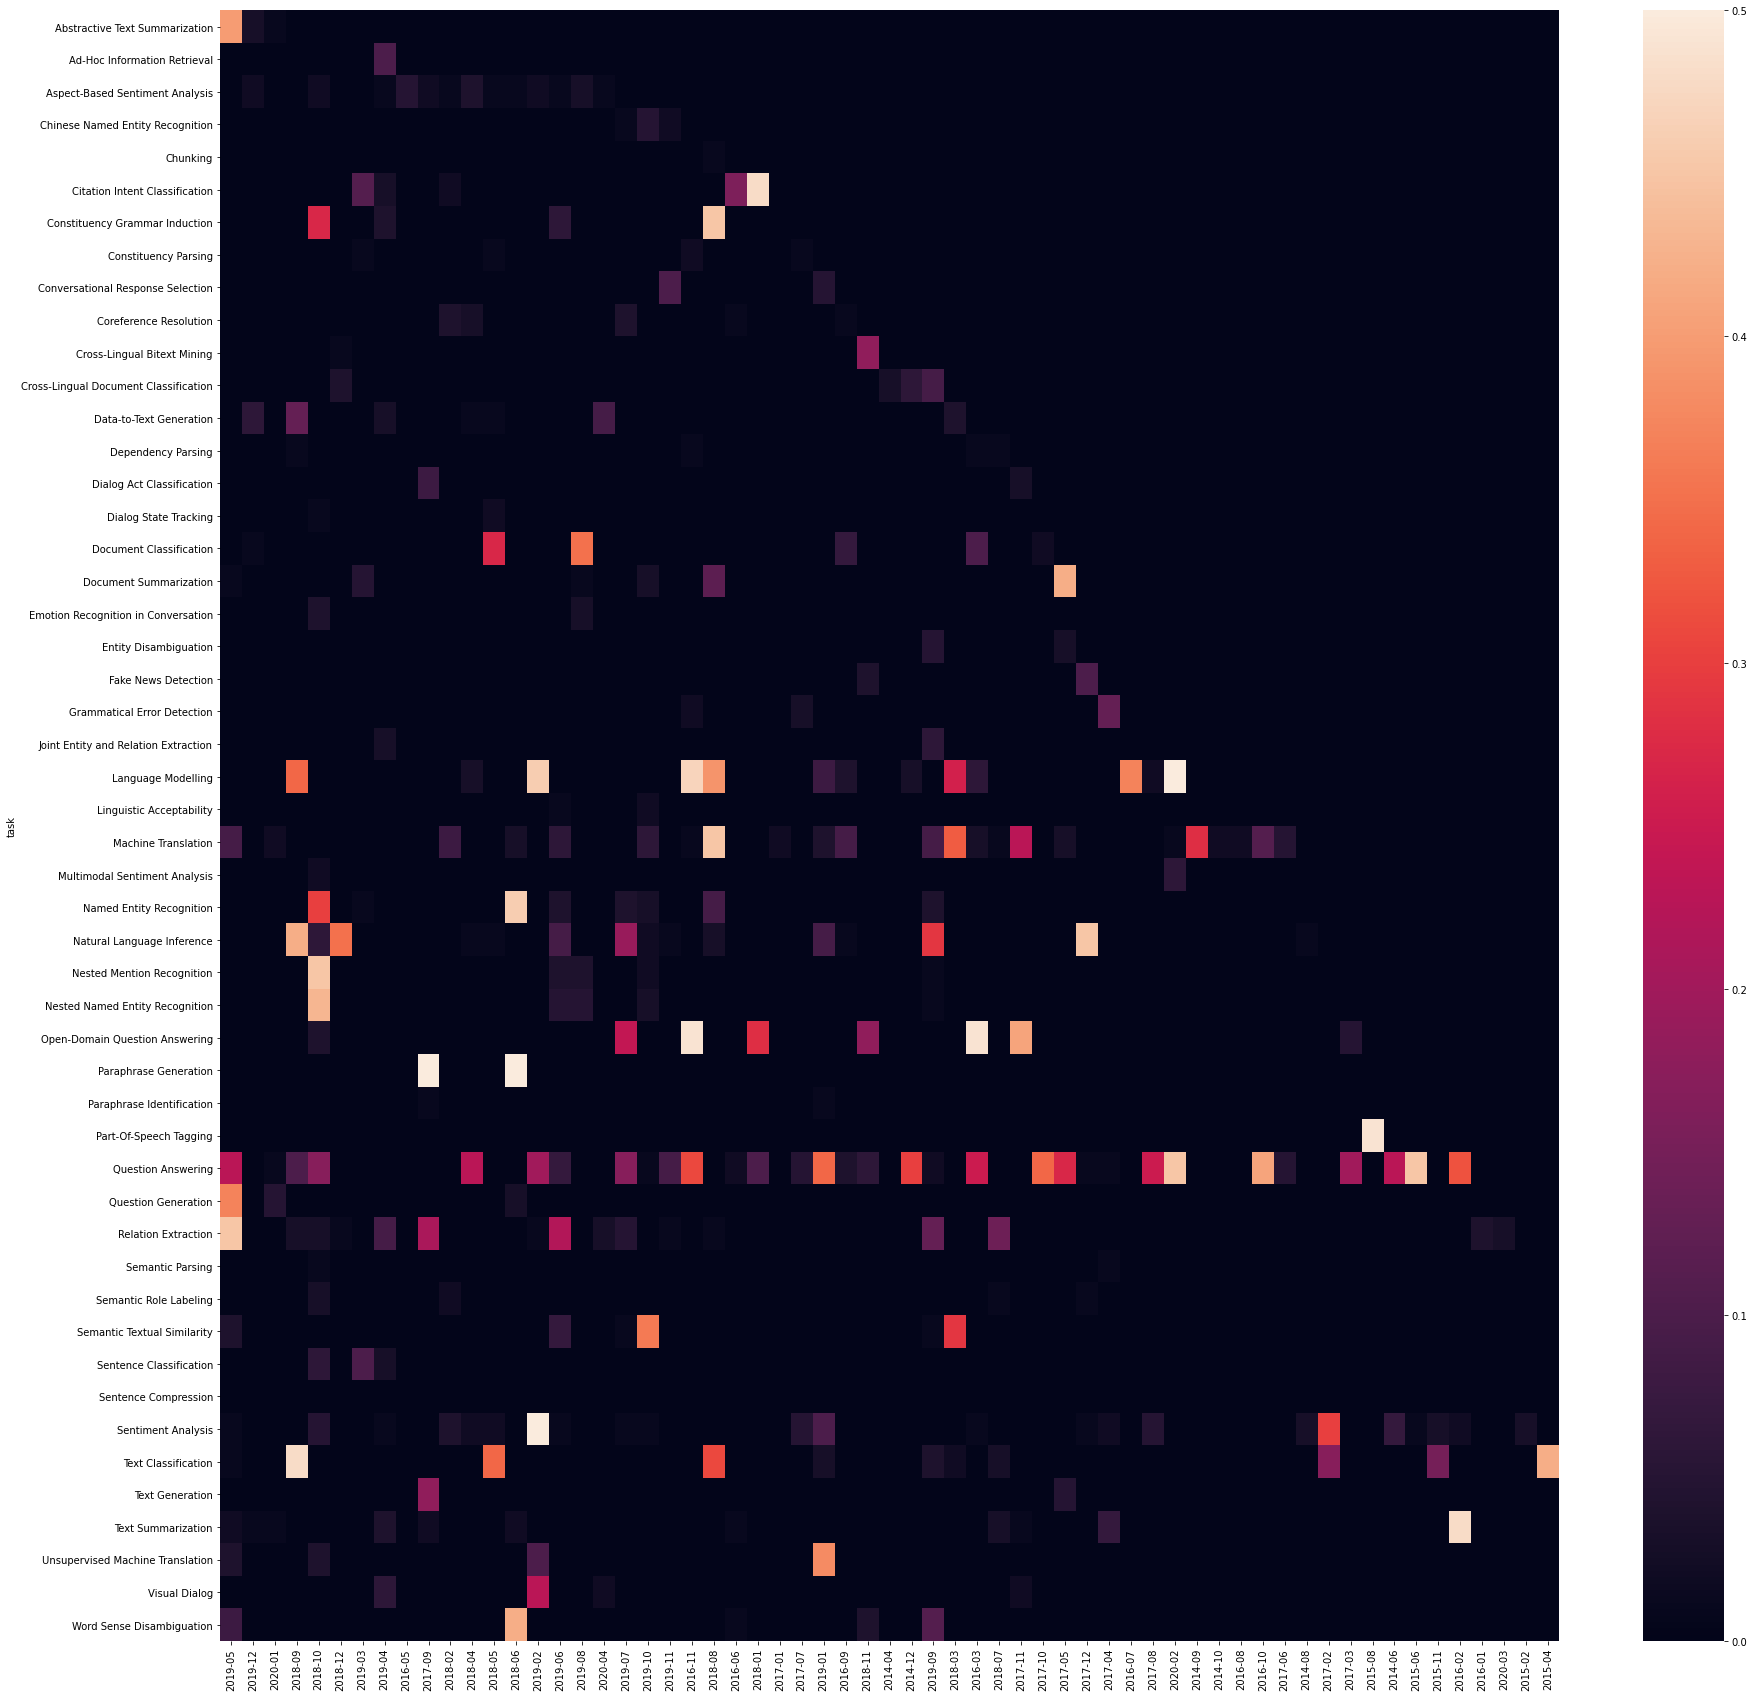

In [39]:
# plot heatmap (better to use clustermap below)
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(input_hc)
plt.savefig("./PLOT_4_plots/heat_task.png")
# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

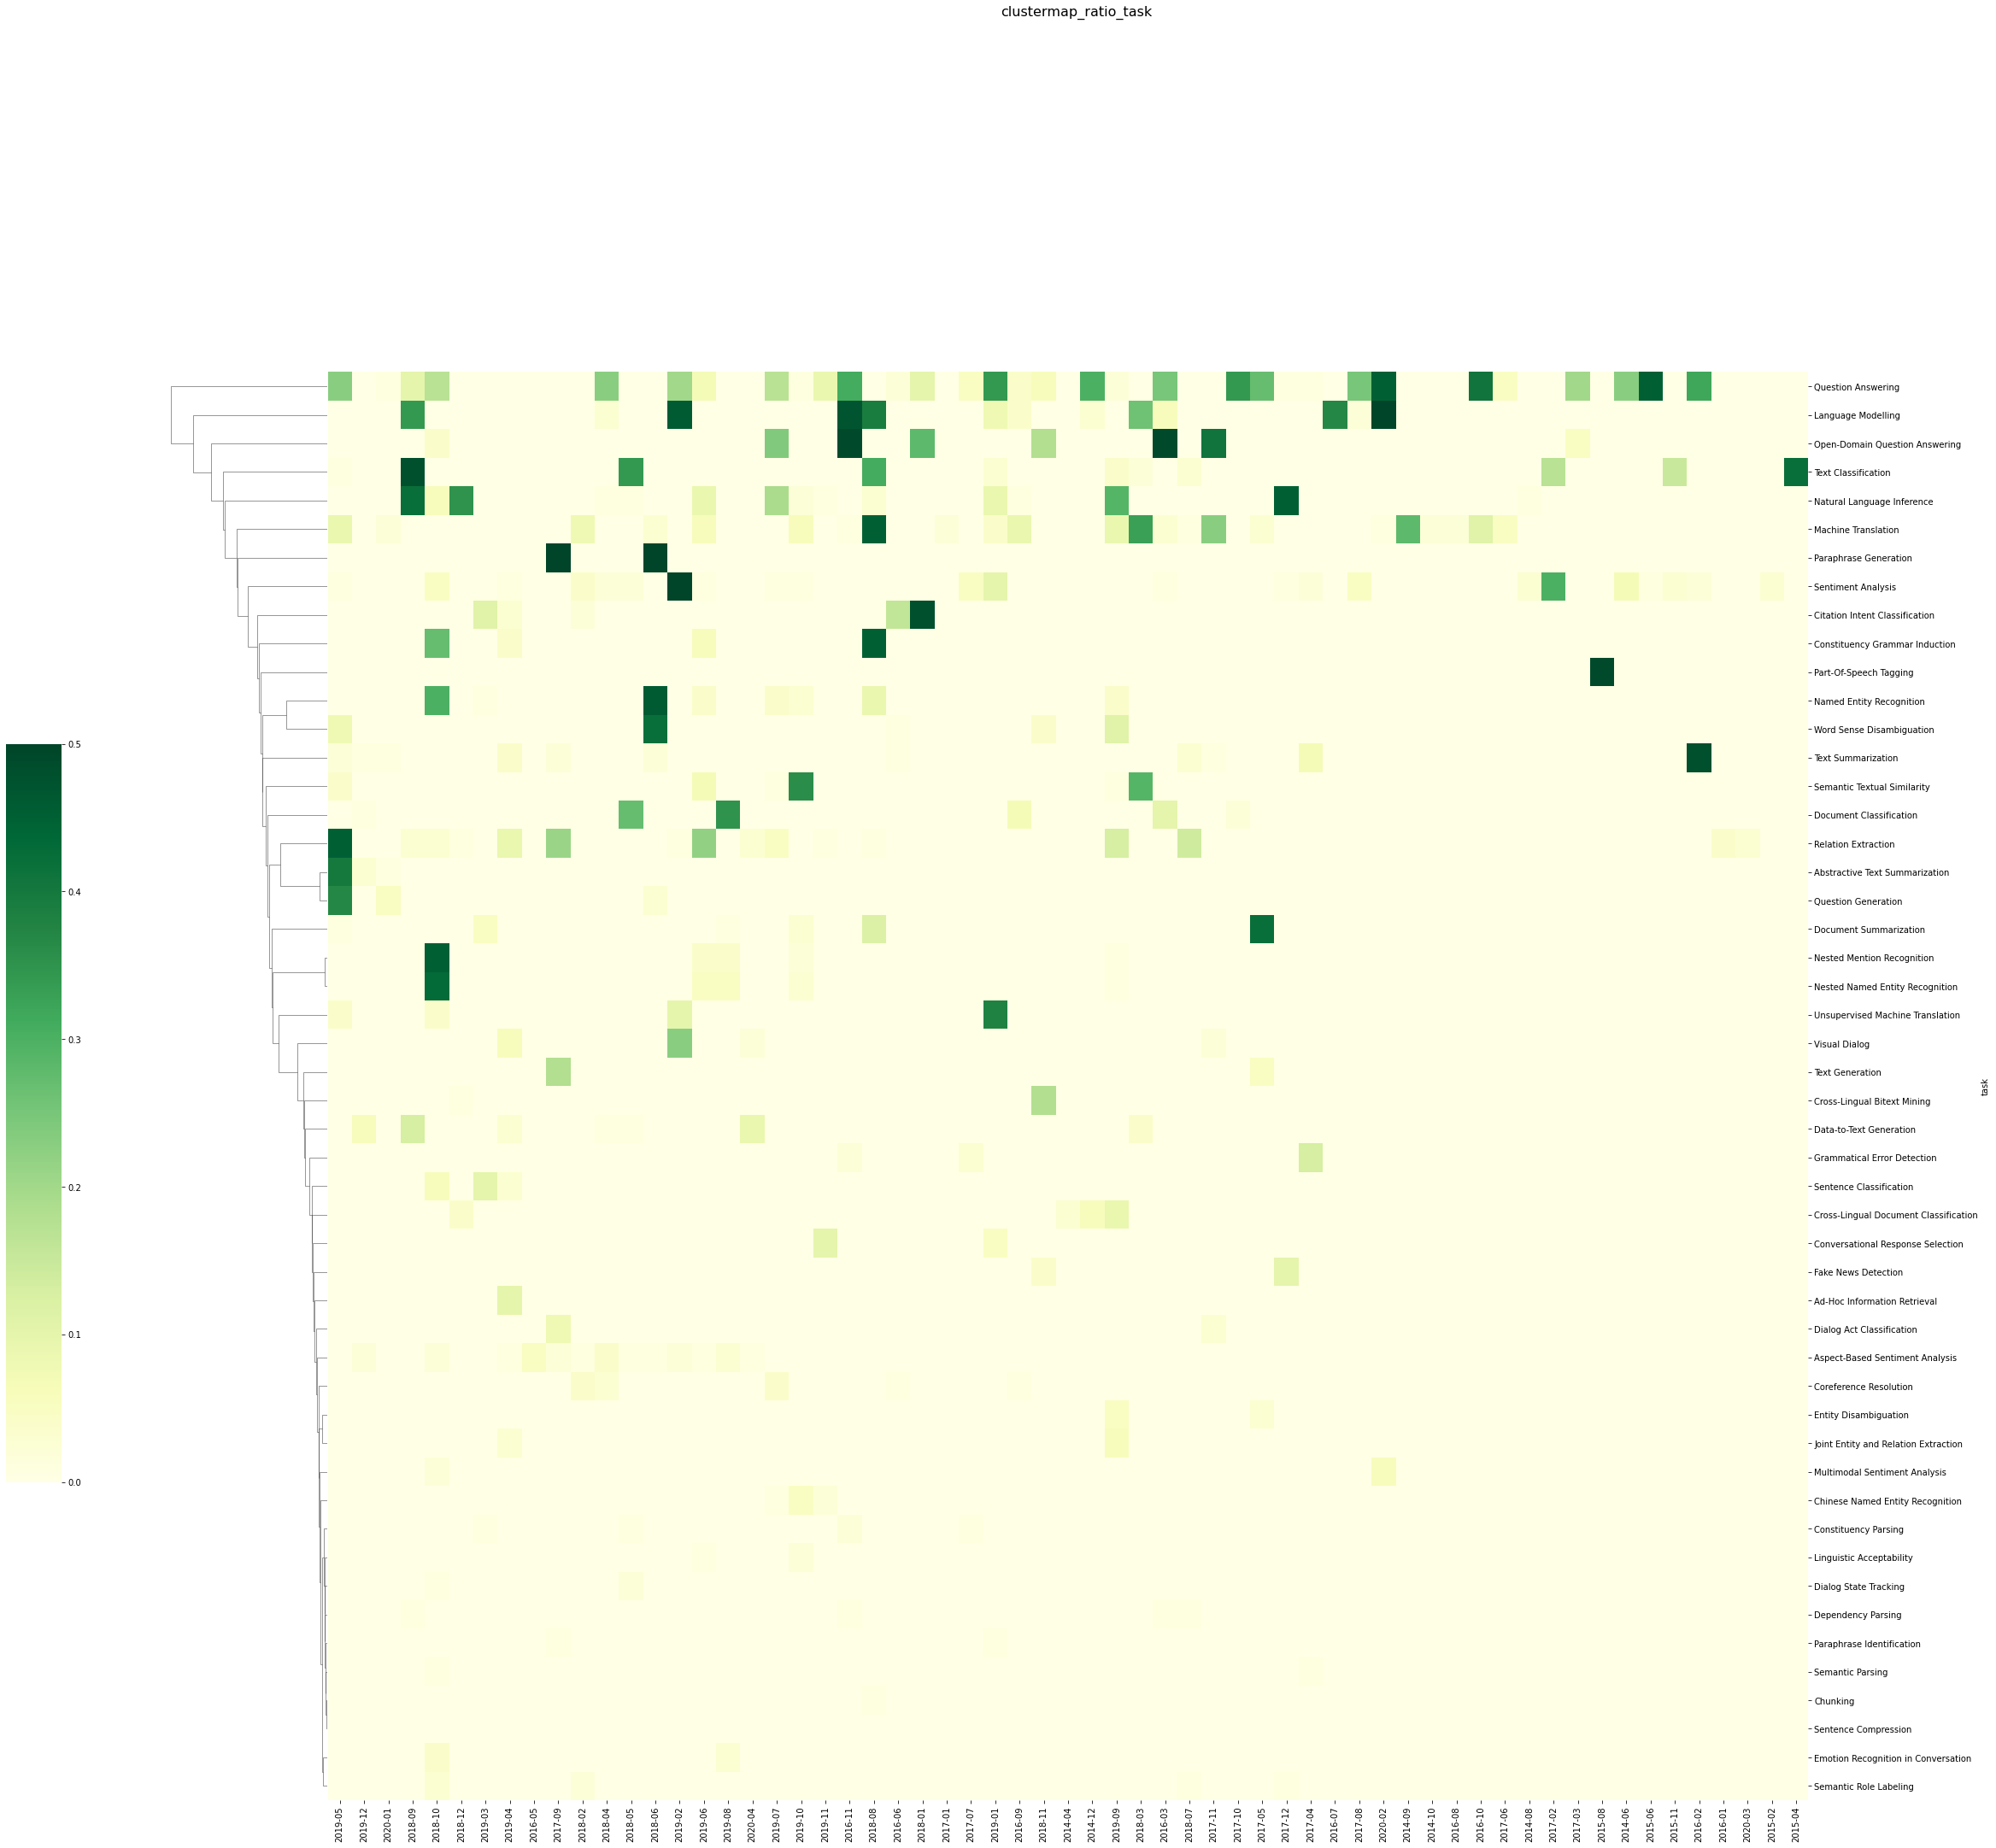

In [40]:
# clustermap showing distance analysis between the tasks
df = df.sort_index(axis=1) # this sorts the columns of the df (dates)
res = sns.clustermap(
    input_hc,
    figsize=(30, 30),
    metric="euclidean",
    cmap="YlGn",
    # row_cluster=False,
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(-0.08, 0.2, 0.03, 0.4),
)
# plt.subplots_adjust(top=0.9)
plt.suptitle("clustermap_ratio_task", y=1, fontsize=16)
plt.savefig("./PLOT_4_plots/clustermap_ratio_task.png")
# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

## Extract the reordered table

In [41]:
# ref
# https://github.com/Stemanz/python_tutorials/blob/master/seaborn/extract_ordered_table_from_heatmap/Retrieve%20ordered%20table%20from%20clustermap.ipynb


def extract_clustered_table(res, data):
    """
    input
    =====
    res:     <sns.matrix.ClusterGrid>  the clustermap object
    data:    <pd.DataFrame>            input table

    output
    ======
    returns: <pd.DataFrame>            reordered input table
    """

    # if sns.clustermap is run with row_cluster=False:
    if res.dendrogram_row is None:
        print("Apparently, rows were not clustered.")
        return -1

    if res.dendrogram_col is not None:
        # reordering index and columns
        new_cols = data.columns[res.dendrogram_col.reordered_ind]
        new_ind = data.index[res.dendrogram_row.reordered_ind]

        return data.loc[new_ind, new_cols]

    else:
        # reordering the index
        new_ind = data.index[res.dendrogram_row.reordered_ind]

        return data.loc[new_ind, :]

In [42]:
#extract the clustered table order
reordered_df = extract_clustered_table(res, df)

In [43]:
#check the number of tasks
len(reordered_df.index.values)

50

In [44]:
#list the tasks
reordered_df.index.values

array(['Question Answering', 'Language Modelling',
       'Open-Domain Question Answering', 'Text Classification',
       'Natural Language Inference', 'Machine Translation',
       'Paraphrase Generation', 'Sentiment Analysis',
       'Citation Intent Classification', 'Constituency Grammar Induction',
       'Part-Of-Speech Tagging', 'Named Entity Recognition',
       'Word Sense Disambiguation', 'Text Summarization',
       'Semantic Textual Similarity', 'Document Classification',
       'Relation Extraction', 'Abstractive Text Summarization',
       'Question Generation', 'Document Summarization',
       'Nested Mention Recognition', 'Nested Named Entity Recognition',
       'Unsupervised Machine Translation', 'Visual Dialog',
       'Text Generation', 'Cross-Lingual Bitext Mining',
       'Data-to-Text Generation', 'Grammatical Error Detection',
       'Sentence Classification', 'Cross-Lingual Document Classification',
       'Conversational Response Selection', 'Fake News Detectio

In [45]:
average_summary_IN.columns

Index(['task', 'date', 'ratio', 'in_trajectory'], dtype='object')

In [46]:
#create a reordered copy of the average df
average_summary_IN2 = pd.DataFrame(columns=average_summary_IN.columns)
#average_summary_IN2

for task in reordered_df.index.values:
    row = average_summary_IN[average_summary_IN.task == task]
    average_summary_IN2 = average_summary_IN2.append(row, ignore_index=True)
#    average_summary_IN2 = average_summary_IN2.append(row)

#this has now the same order of the clustered results
average_summary_IN2

,task,date,ratio,in_trajectory
0,Question Answering,2014-06,0.230,IN
1,Question Answering,2014-12,0.300,IN
2,Question Answering,2015-06,0.450,IN
3,Question Answering,2015-11,0.001,IN
4,Question Answering,2016-02,0.320,IN
...,...,...,...,...
325,Emotion Recognition in Conversation,2019-08,0.030,IN
326,Semantic Role Labeling,2017-12,0.010,IN
327,Semantic Role Labeling,2018-02,0.020,IN
328,Semantic Role Labeling,2018-07,0.010,IN


In [47]:
fig_traj = px.line(average_summary_IN2, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj.add_trace(
    go.Scatter(
        x=average_summary_IN2["date"],
        y=average_summary_IN2["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN2["task"]
        + "<BR>task: "
        + average_summary_IN2["task"]
        + "<BR>date: "
        + average_summary_IN2["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN2["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN2["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj.update_layout(
    title="Trajectory for ratio (task per year)",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj, "./PLOT_4_plots/fig_traj.png")

### Use the proportionalized average_summary

In [48]:
#make sure all ratio have a non-zero value.
average_summary_IN2[average_summary_IN2.ratio==0]

,task,date,ratio,in_trajectory


In [49]:
#create average_summary_IN2_SUM, with the sum of ratios per taks
average_summary_IN2_SUM = pd.DataFrame(average_summary_IN2.groupby(['task']).sum())
#move index to column
average_summary_IN2_SUM = average_summary_IN2_SUM.reset_index(level='task')

#average_summary_IN_SUM[average_summary_IN_SUM.task=="Chunking"].ratio.iloc[0]

#copy the proportionalized data frame
average_summary_IN2_prop = average_summary_IN2.copy()
average_summary_IN2_prop.reset_index()

#iterate the average_summary_IN_prop and change the values accordingly
for i in average_summary_IN2_prop.index.values:
    average_summary_IN2_prop.loc[i,"ratio"] = average_summary_IN2_prop.loc[i,"ratio"] / average_summary_IN2_SUM[average_summary_IN2_SUM.task==average_summary_IN2_prop.loc[i,"task"]].ratio.iloc[0]

#this is the proportionalized df
average_summary_IN2_prop

,task,date,ratio,in_trajectory
0,Question Answering,2014-06,0.039917,IN
1,Question Answering,2014-12,0.052065,IN
2,Question Answering,2015-06,0.078098,IN
3,Question Answering,2015-11,0.000174,IN
4,Question Answering,2016-02,0.055536,IN
...,...,...,...,...
325,Emotion Recognition in Conversation,2019-08,0.416667,IN
326,Semantic Role Labeling,2017-12,0.142857,IN
327,Semantic Role Labeling,2018-02,0.285714,IN
328,Semantic Role Labeling,2018-07,0.142857,IN


In [50]:
#Compare raw values...
average_summary_IN2[average_summary_IN2.task=="Question Answering"]

,task,date,ratio,in_trajectory
0,Question Answering,2014-06,0.230,IN
1,Question Answering,2014-12,0.300,IN
2,Question Answering,2015-06,0.450,IN
3,Question Answering,2015-11,0.001,IN
4,Question Answering,2016-02,0.320,IN
...,...,...,...,...
29,Question Answering,2019-09,0.020,IN
30,Question Answering,2019-10,0.010,IN
31,Question Answering,2019-11,0.090,IN
32,Question Answering,2020-01,0.010,IN


In [51]:
#...with normalized values.
average_summary_IN3 = average_summary_IN2_prop.copy()

average_summary_IN3[average_summary_IN3.task=="Question Answering"]

,task,date,ratio,in_trajectory
0,Question Answering,2014-06,0.039917,IN
1,Question Answering,2014-12,0.052065,IN
2,Question Answering,2015-06,0.078098,IN
3,Question Answering,2015-11,0.000174,IN
4,Question Answering,2016-02,0.055536,IN
...,...,...,...,...
29,Question Answering,2019-09,0.003471,IN
30,Question Answering,2019-10,0.001736,IN
31,Question Answering,2019-11,0.015620,IN
32,Question Answering,2020-01,0.001736,IN


In [52]:
#plot now the trajectory using the normalized values

In [53]:
fig_traj_norm = px.line(average_summary_IN3, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj_norm.add_trace(
    go.Scatter(
        x=average_summary_IN3["date"],
        y=average_summary_IN3["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN3["task"]
        + "<BR>task: "
        + average_summary_IN3["task"]
        + "<BR>date: "
        + average_summary_IN3["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN3["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN3["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj_norm.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj_norm.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj_norm.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj_norm.update_layout(
    title="Trajectory for ratio (task per year) - Normalized",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj_norm.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj_norm, "./PLOT_4_plots/fig_traj_norm.png")

In [54]:
#Prepare and run HC for the Normalized average_summary_IN3 df

df_melted = pd.melt(average_summary_IN3, id_vars=["task", "date"], value_vars=["ratio"])

df_melted["value"].astype(float)

#this sets the DS as leaves for the  clustering entities
df=pd.DataFrame(columns=df_melted["date"].unique())

df["task"]=df_melted["task"].unique()

df=df.set_index("task")

for ds in df_melted["task"].unique():
    for var in df_melted["date"].unique():
    #print(ds)
        value = df_melted[(df_melted["task"]==ds)&(df_melted["date"]==var)]["value"]
        if(len(value)>0):
            print(ds,"\t",var,"\t",value.iloc[0])
            df.loc[ds,var] = value.iloc[0]
            #df = df.append(pd.Series({var: value}, name=ds))
        else:
            print(ds,"\t",var,"\t0",)
            #df(ds)[var] = "NaN"
            #df = df.append(pd.Series({var: "NaN"}, name=ds))   
df = df.fillna(0)

report = pd.DataFrame(df.describe().T)
report = report.sort_values(by="count", ascending=False)

#get here the top (unique>10) variables to use for the HC 
#Obs: in this case if we use the task as clustering entities, then it doesn't make sense to filter. Just use every thing
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

report = pd.DataFrame(df.describe().T)

report=report.sort_values(by='count', ascending=False)

#select variables that have been colected at least by 10 benchmarks
#when using tasks for clustering, keep it >0
unique_vars = list(report[report["count"]>0].index.unique())

#col_filter
#df.filter(regex=col_filter)

input_hc = df[df.columns.intersection(unique_vars)]


Question Answering 	 2014-06 	 0.0399166955918084
Question Answering 	 2014-12 	 0.05206525511975009
Question Answering 	 2015-06 	 0.07809788267962514
Question Answering 	 2015-11 	 0.00017355085039916698
Question Answering 	 2016-02 	 0.05553627212773343
Question Answering 	 2016-03 	 0.04338771259979174
Question Answering 	 2016-06 	 0.0034710170079833395
Question Answering 	 2016-09 	 0.006942034015966679
Question Answering 	 2016-10 	 0.07115584866365846
Question Answering 	 2016-11 	 0.05380076362374176
Question Answering 	 2017-03 	 0.034710170079833395
Question Answering 	 2017-04 	 0.0017355085039916698
Question Answering 	 2017-05 	 0.04685872960777508
Question Answering 	 2017-06 	 0.008677542519958349
Question Answering 	 2017-07 	 0.008677542519958349
Question Answering 	 2017-08 	 0.04338771259979174
Question Answering 	 2017-10 	 0.059007289135716776
Question Answering 	 2017-12 	 0.0017355085039916698
Question Answering 	 2018-01 	 0.017355085039916698
Question Answerin

Machine Translation 	 2016-09 	 0.041666666666666664
Machine Translation 	 2016-10 	 0.05092592592592592
Machine Translation 	 2016-11 	 0.004629629629629629
Machine Translation 	 2017-03 	0
Machine Translation 	 2017-04 	0
Machine Translation 	 2017-05 	 0.013888888888888888
Machine Translation 	 2017-06 	 0.023148148148148147
Machine Translation 	 2017-07 	0
Machine Translation 	 2017-08 	0
Machine Translation 	 2017-10 	0
Machine Translation 	 2017-12 	0
Machine Translation 	 2018-01 	0
Machine Translation 	 2018-04 	0
Machine Translation 	 2018-09 	0
Machine Translation 	 2018-10 	0
Machine Translation 	 2018-11 	0
Machine Translation 	 2019-01 	 0.018518518518518517
Machine Translation 	 2019-02 	0
Machine Translation 	 2019-05 	 0.041666666666666664
Machine Translation 	 2019-06 	 0.027777777777777776
Machine Translation 	 2019-07 	0
Machine Translation 	 2019-08 	0
Machine Translation 	 2019-09 	 0.041666666666666664
Machine Translation 	 2019-10 	 0.027777777777777776
Machine T

Part-Of-Speech Tagging 	 2019-08 	 0.002028397565922921
Part-Of-Speech Tagging 	 2019-09 	0
Part-Of-Speech Tagging 	 2019-10 	0
Part-Of-Speech Tagging 	 2019-11 	0
Part-Of-Speech Tagging 	 2020-01 	0
Part-Of-Speech Tagging 	 2020-02 	0
Part-Of-Speech Tagging 	 2016-07 	0
Part-Of-Speech Tagging 	 2017-11 	 0.002028397565922921
Part-Of-Speech Tagging 	 2018-03 	0
Part-Of-Speech Tagging 	 2018-08 	0
Part-Of-Speech Tagging 	 2015-04 	0
Part-Of-Speech Tagging 	 2017-02 	0
Part-Of-Speech Tagging 	 2018-05 	 0.002028397565922921
Part-Of-Speech Tagging 	 2018-07 	0
Part-Of-Speech Tagging 	 2014-08 	0
Part-Of-Speech Tagging 	 2017-09 	0
Part-Of-Speech Tagging 	 2018-12 	0
Part-Of-Speech Tagging 	 2014-09 	0
Part-Of-Speech Tagging 	 2014-10 	0
Part-Of-Speech Tagging 	 2016-08 	0
Part-Of-Speech Tagging 	 2017-01 	0
Part-Of-Speech Tagging 	 2018-02 	0
Part-Of-Speech Tagging 	 2018-06 	0
Part-Of-Speech Tagging 	 2015-02 	0
Part-Of-Speech Tagging 	 2019-04 	0
Part-Of-Speech Tagging 	 2019-03 	0
Part

Document Classification 	 2018-12 	0
Document Classification 	 2014-09 	0
Document Classification 	 2014-10 	0
Document Classification 	 2016-08 	0
Document Classification 	 2017-01 	0
Document Classification 	 2018-02 	0
Document Classification 	 2018-06 	0
Document Classification 	 2015-02 	0
Document Classification 	 2019-04 	0
Document Classification 	 2019-03 	0
Document Classification 	 2015-08 	0
Document Classification 	 2019-12 	 0.0121654501216545
Document Classification 	 2016-01 	0
Document Classification 	 2020-03 	0
Document Classification 	 2020-04 	0
Document Classification 	 2014-04 	0
Document Classification 	 2016-05 	0
Relation Extraction 	 2014-06 	0
Relation Extraction 	 2014-12 	0
Relation Extraction 	 2015-06 	0
Relation Extraction 	 2015-11 	0
Relation Extraction 	 2016-02 	0
Relation Extraction 	 2016-03 	0
Relation Extraction 	 2016-06 	0
Relation Extraction 	 2016-09 	0
Relation Extraction 	 2016-10 	0
Relation Extraction 	 2016-11 	0
Relation Extraction 	 2

Nested Mention Recognition 	 2014-04 	0
Nested Mention Recognition 	 2016-05 	0
Nested Named Entity Recognition 	 2014-06 	0
Nested Named Entity Recognition 	 2014-12 	0
Nested Named Entity Recognition 	 2015-06 	0
Nested Named Entity Recognition 	 2015-11 	0
Nested Named Entity Recognition 	 2016-02 	0
Nested Named Entity Recognition 	 2016-03 	0
Nested Named Entity Recognition 	 2016-06 	0
Nested Named Entity Recognition 	 2016-09 	0
Nested Named Entity Recognition 	 2016-10 	0
Nested Named Entity Recognition 	 2016-11 	0
Nested Named Entity Recognition 	 2017-03 	0
Nested Named Entity Recognition 	 2017-04 	0
Nested Named Entity Recognition 	 2017-05 	0
Nested Named Entity Recognition 	 2017-06 	0
Nested Named Entity Recognition 	 2017-07 	0
Nested Named Entity Recognition 	 2017-08 	0
Nested Named Entity Recognition 	 2017-10 	0
Nested Named Entity Recognition 	 2017-12 	0
Nested Named Entity Recognition 	 2018-01 	0
Nested Named Entity Recognition 	 2018-04 	0
Nested Named Entity 

Data-to-Text Generation 	 2017-06 	0
Data-to-Text Generation 	 2017-07 	0
Data-to-Text Generation 	 2017-08 	0
Data-to-Text Generation 	 2017-10 	0
Data-to-Text Generation 	 2017-12 	0
Data-to-Text Generation 	 2018-01 	0
Data-to-Text Generation 	 2018-04 	 0.026954177897574125
Data-to-Text Generation 	 2018-09 	 0.3504043126684636
Data-to-Text Generation 	 2018-10 	0
Data-to-Text Generation 	 2018-11 	 0.0026954177897574125
Data-to-Text Generation 	 2019-01 	0
Data-to-Text Generation 	 2019-02 	0
Data-to-Text Generation 	 2019-05 	0
Data-to-Text Generation 	 2019-06 	0
Data-to-Text Generation 	 2019-07 	0
Data-to-Text Generation 	 2019-08 	0
Data-to-Text Generation 	 2019-09 	0
Data-to-Text Generation 	 2019-10 	0
Data-to-Text Generation 	 2019-11 	0
Data-to-Text Generation 	 2020-01 	0
Data-to-Text Generation 	 2020-02 	0
Data-to-Text Generation 	 2016-07 	0
Data-to-Text Generation 	 2017-11 	0
Data-to-Text Generation 	 2018-03 	 0.1078167115902965
Data-to-Text Generation 	 2018-08 	

Conversational Response Selection 	 2018-06 	0
Conversational Response Selection 	 2015-02 	0
Conversational Response Selection 	 2019-04 	0
Conversational Response Selection 	 2019-03 	0
Conversational Response Selection 	 2015-08 	0
Conversational Response Selection 	 2019-12 	0
Conversational Response Selection 	 2016-01 	0
Conversational Response Selection 	 2020-03 	0
Conversational Response Selection 	 2020-04 	0
Conversational Response Selection 	 2014-04 	0
Conversational Response Selection 	 2016-05 	0
Fake News Detection 	 2014-06 	0
Fake News Detection 	 2014-12 	0
Fake News Detection 	 2015-06 	0
Fake News Detection 	 2015-11 	0
Fake News Detection 	 2016-02 	0
Fake News Detection 	 2016-03 	0
Fake News Detection 	 2016-06 	0
Fake News Detection 	 2016-09 	0
Fake News Detection 	 2016-10 	0
Fake News Detection 	 2016-11 	0
Fake News Detection 	 2017-03 	0
Fake News Detection 	 2017-04 	0
Fake News Detection 	 2017-05 	0
Fake News Detection 	 2017-06 	0
Fake News Detection 	

Entity Disambiguation 	 2019-05 	0
Entity Disambiguation 	 2019-06 	0
Entity Disambiguation 	 2019-07 	0
Entity Disambiguation 	 2019-08 	0
Entity Disambiguation 	 2019-09 	 0.625
Entity Disambiguation 	 2019-10 	0
Entity Disambiguation 	 2019-11 	0
Entity Disambiguation 	 2020-01 	0
Entity Disambiguation 	 2020-02 	0
Entity Disambiguation 	 2016-07 	0
Entity Disambiguation 	 2017-11 	0
Entity Disambiguation 	 2018-03 	0
Entity Disambiguation 	 2018-08 	0
Entity Disambiguation 	 2015-04 	0
Entity Disambiguation 	 2017-02 	0
Entity Disambiguation 	 2018-05 	0
Entity Disambiguation 	 2018-07 	0
Entity Disambiguation 	 2014-08 	0
Entity Disambiguation 	 2017-09 	0
Entity Disambiguation 	 2018-12 	0
Entity Disambiguation 	 2014-09 	0
Entity Disambiguation 	 2014-10 	0
Entity Disambiguation 	 2016-08 	0
Entity Disambiguation 	 2017-01 	0
Entity Disambiguation 	 2018-02 	0
Entity Disambiguation 	 2018-06 	0
Entity Disambiguation 	 2015-02 	0
Entity Disambiguation 	 2019-04 	0
Entity Disambig

Chinese Named Entity Recognition 	 2018-12 	0
Chinese Named Entity Recognition 	 2014-09 	0
Chinese Named Entity Recognition 	 2014-10 	0
Chinese Named Entity Recognition 	 2016-08 	0
Chinese Named Entity Recognition 	 2017-01 	0
Chinese Named Entity Recognition 	 2018-02 	0
Chinese Named Entity Recognition 	 2018-06 	0
Chinese Named Entity Recognition 	 2015-02 	0
Chinese Named Entity Recognition 	 2019-04 	0
Chinese Named Entity Recognition 	 2019-03 	0
Chinese Named Entity Recognition 	 2015-08 	0
Chinese Named Entity Recognition 	 2019-12 	0
Chinese Named Entity Recognition 	 2016-01 	0
Chinese Named Entity Recognition 	 2020-03 	0
Chinese Named Entity Recognition 	 2020-04 	0
Chinese Named Entity Recognition 	 2014-04 	0
Chinese Named Entity Recognition 	 2016-05 	0
Constituency Parsing 	 2014-06 	0
Constituency Parsing 	 2014-12 	0
Constituency Parsing 	 2015-06 	0
Constituency Parsing 	 2015-11 	0
Constituency Parsing 	 2016-02 	0
Constituency Parsing 	 2016-03 	0
Constituency P

Paraphrase Identification 	 2020-03 	0
Paraphrase Identification 	 2020-04 	0
Paraphrase Identification 	 2014-04 	0
Paraphrase Identification 	 2016-05 	0
Semantic Parsing 	 2014-06 	0
Semantic Parsing 	 2014-12 	0
Semantic Parsing 	 2015-06 	0
Semantic Parsing 	 2015-11 	0
Semantic Parsing 	 2016-02 	0
Semantic Parsing 	 2016-03 	0
Semantic Parsing 	 2016-06 	0
Semantic Parsing 	 2016-09 	0
Semantic Parsing 	 2016-10 	0
Semantic Parsing 	 2016-11 	0
Semantic Parsing 	 2017-03 	0
Semantic Parsing 	 2017-04 	 0.5
Semantic Parsing 	 2017-05 	0
Semantic Parsing 	 2017-06 	0
Semantic Parsing 	 2017-07 	0
Semantic Parsing 	 2017-08 	0
Semantic Parsing 	 2017-10 	0
Semantic Parsing 	 2017-12 	0
Semantic Parsing 	 2018-01 	0
Semantic Parsing 	 2018-04 	0
Semantic Parsing 	 2018-09 	0
Semantic Parsing 	 2018-10 	 0.5
Semantic Parsing 	 2018-11 	0
Semantic Parsing 	 2019-01 	0
Semantic Parsing 	 2019-02 	0
Semantic Parsing 	 2019-05 	0
Semantic Parsing 	 2019-06 	0
Semantic Parsing 	 2019-07 	

In [55]:
df.head(3)

,2014-06,2014-12,2015-06,2015-11,2016-02,2016-03,2016-06,2016-09,2016-10,2016-11,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-10,2017-12,2018-01,2018-04,2018-09,2018-10,2018-11,2019-01,2019-02,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2020-01,2020-02,2016-07,2017-11,2018-03,2018-08,2015-04,2017-02,2018-05,2018-07,2014-08,2017-09,2018-12,2014-09,2014-10,2016-08,2017-01,2018-02,2018-06,2015-02,2019-04,2019-03,2015-08,2019-12,2016-01,2020-03,2020-04,2014-04,2016-05
task,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Question Answering,0.039917,0.052065,0.078098,0.000174,0.055536,0.043388,0.003471,0.006942,0.071156,0.053801,0.034710,0.001736,0.046859,0.008678,0.008678,0.043388,0.059007,0.001736,0.017355,0.039917,0.017355,0.029504,0.010413,0.059007,0.034710,0.039917,0.012149,0.029504,0.000174,0.003471,0.001736,0.01562,0.001736,0.078098,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Language Modelling,0.000000,0.009826,0.000000,0.000000,0.000000,0.019653,0.000000,0.013102,0.000000,0.153947,0.000000,0.000000,0.000328,0.000000,0.000000,0.006551,0.000328,0.000000,0.000000,0.009826,0.111366,0.000000,0.000000,0.026204,0.150671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.163773,0.121192,0.000328,0.085162,0.127743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Open-Domain Question Answering,0.000000,0.000000,0.000000,0.000000,0.000000,0.224771,0.000000,0.000000,0.000000,0.224771,0.022936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128440,0.000000,0.000000,0.018349,0.082569,0.000000,0.000000,0.000000,0.000000,0.110092,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.188073,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


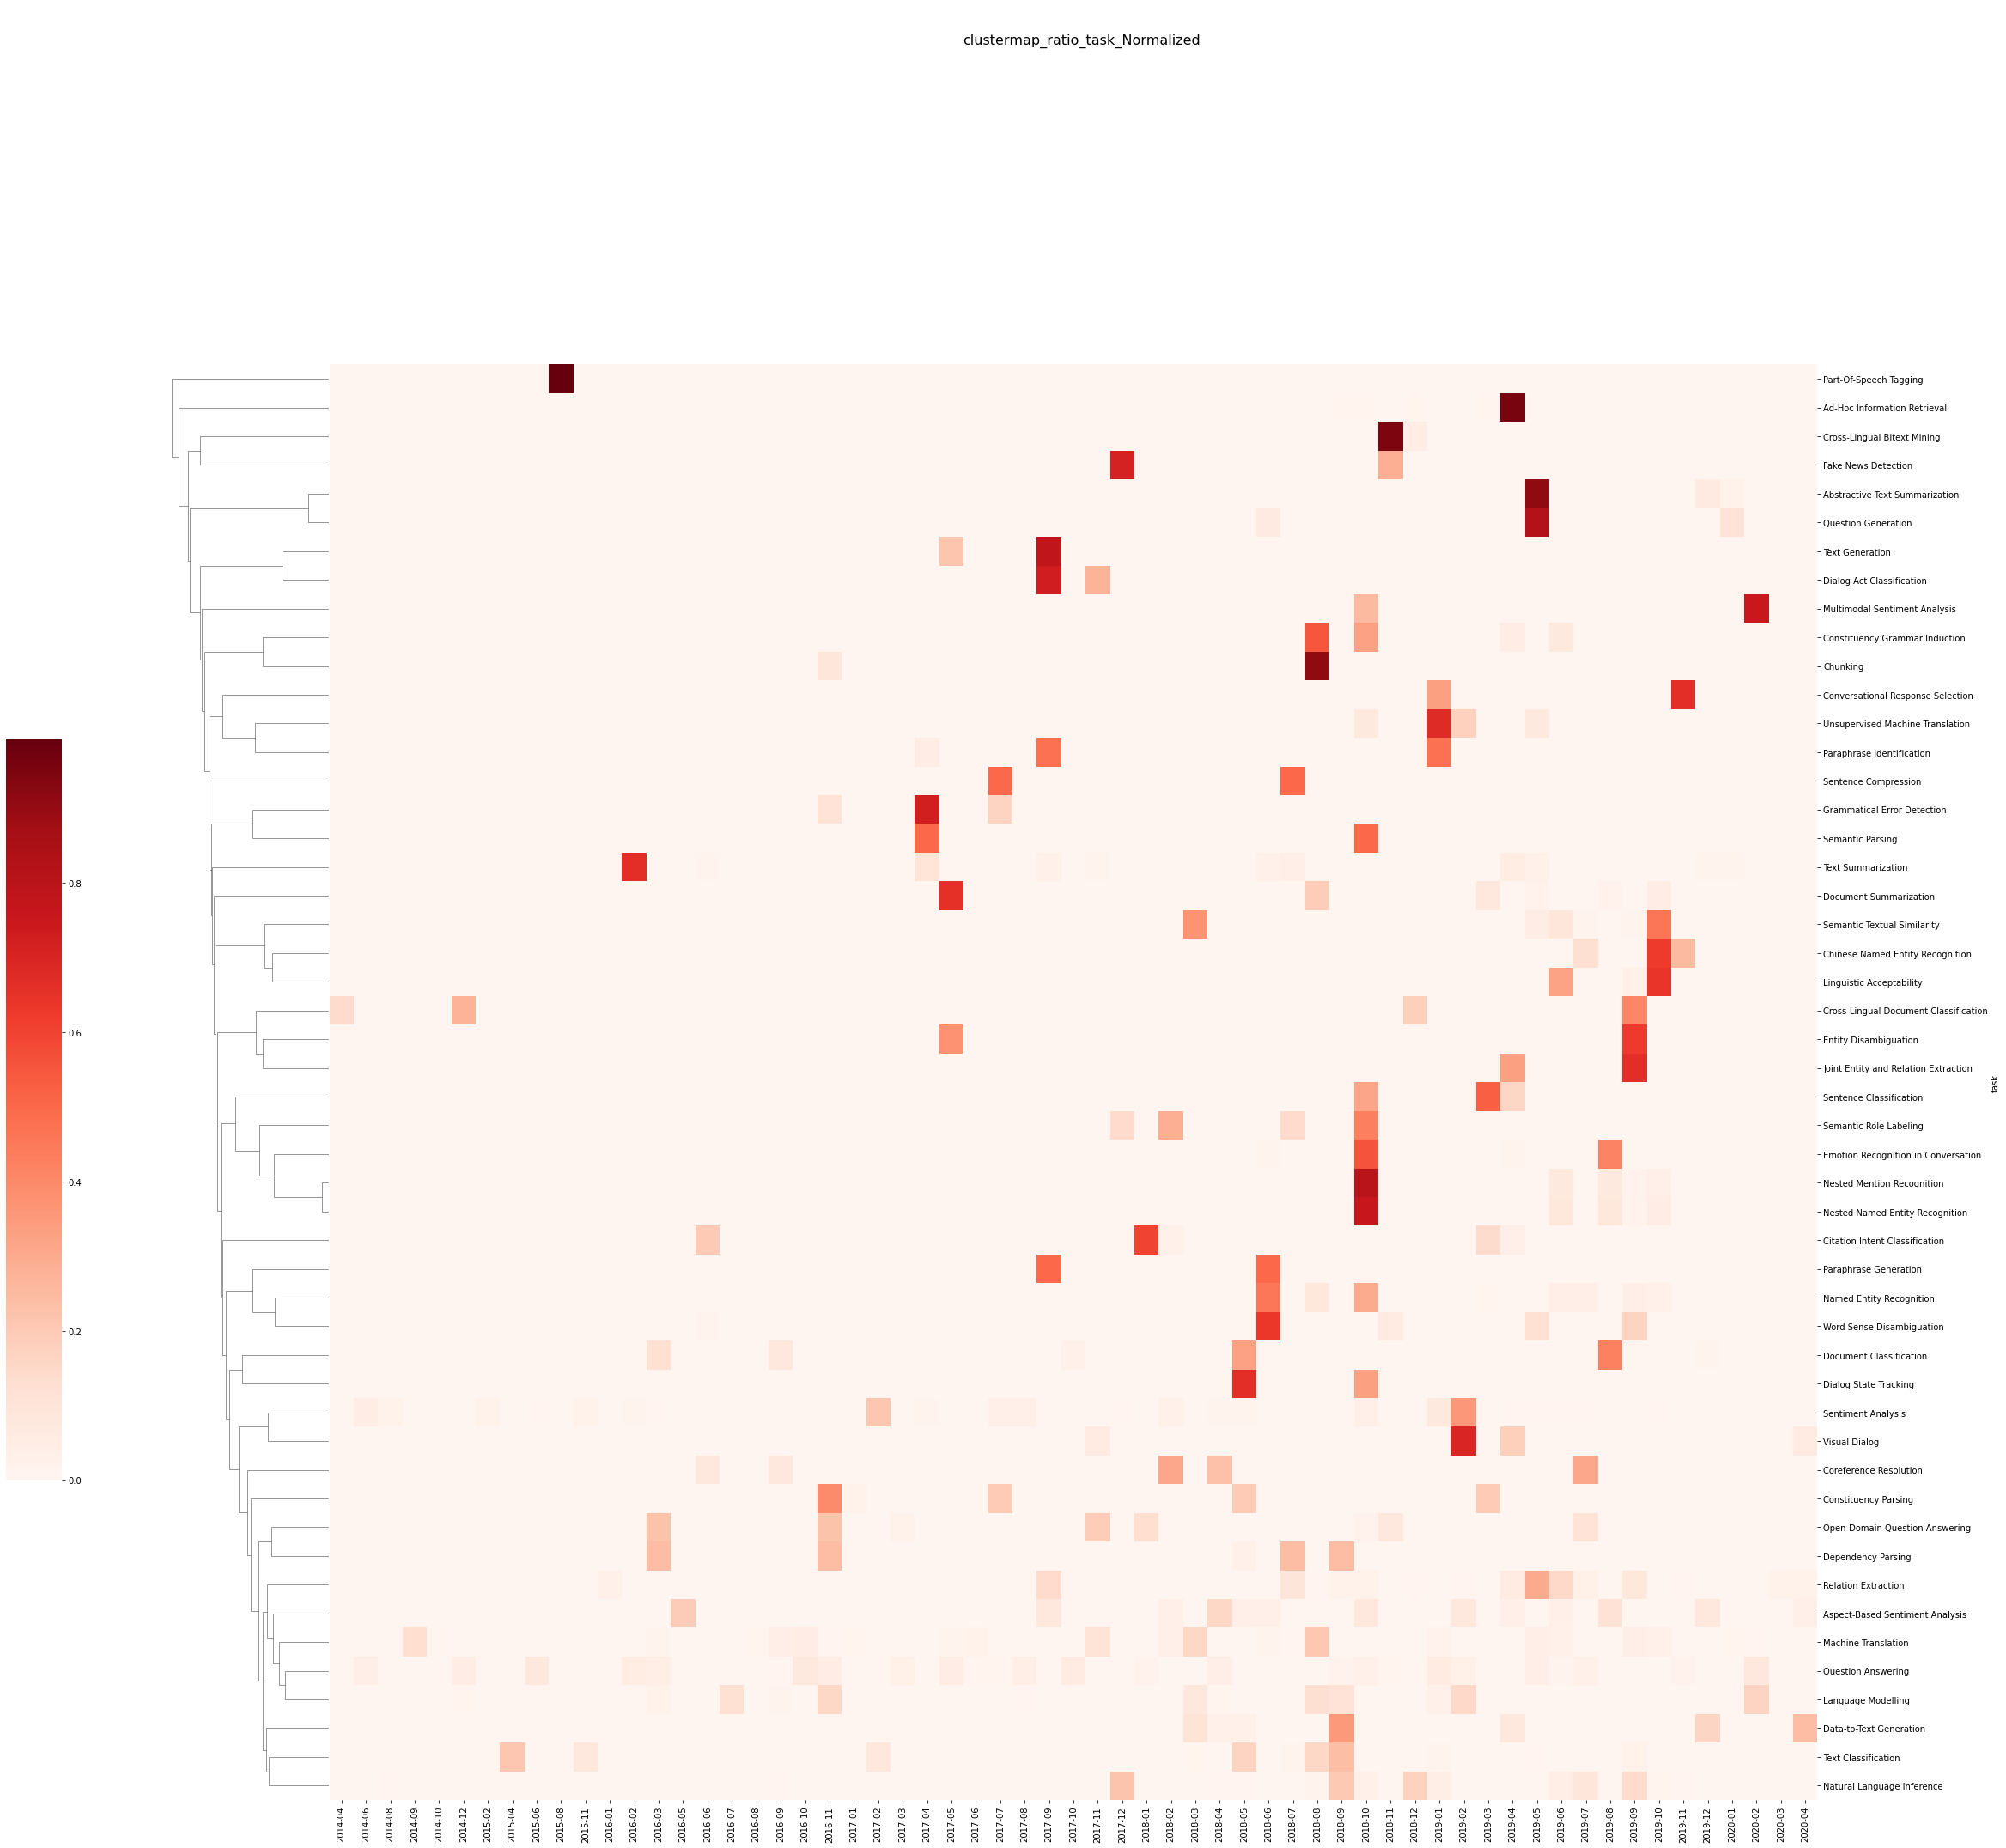

In [56]:
df = df.sort_index(axis=1) # this sorts the columns of the df (dates)
##Plot HC
#df=df.sort_values(by=['col1'])
# clustermap showing distance analysis between the tasks
res2 = sns.clustermap(
    df,
    figsize=(30, 30),
    metric="euclidean",
    cmap="Reds",
    # row_cluster=False,
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(-0.08, 0.2, 0.03, 0.4),
)
# plt.subplots_adjust(top=0.9)

plt.suptitle("clustermap_ratio_task_Normalized", fontsize=16)
plt.savefig("./PLOT_4_plots/clustermap_ratio_task_Normalized.png")

# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

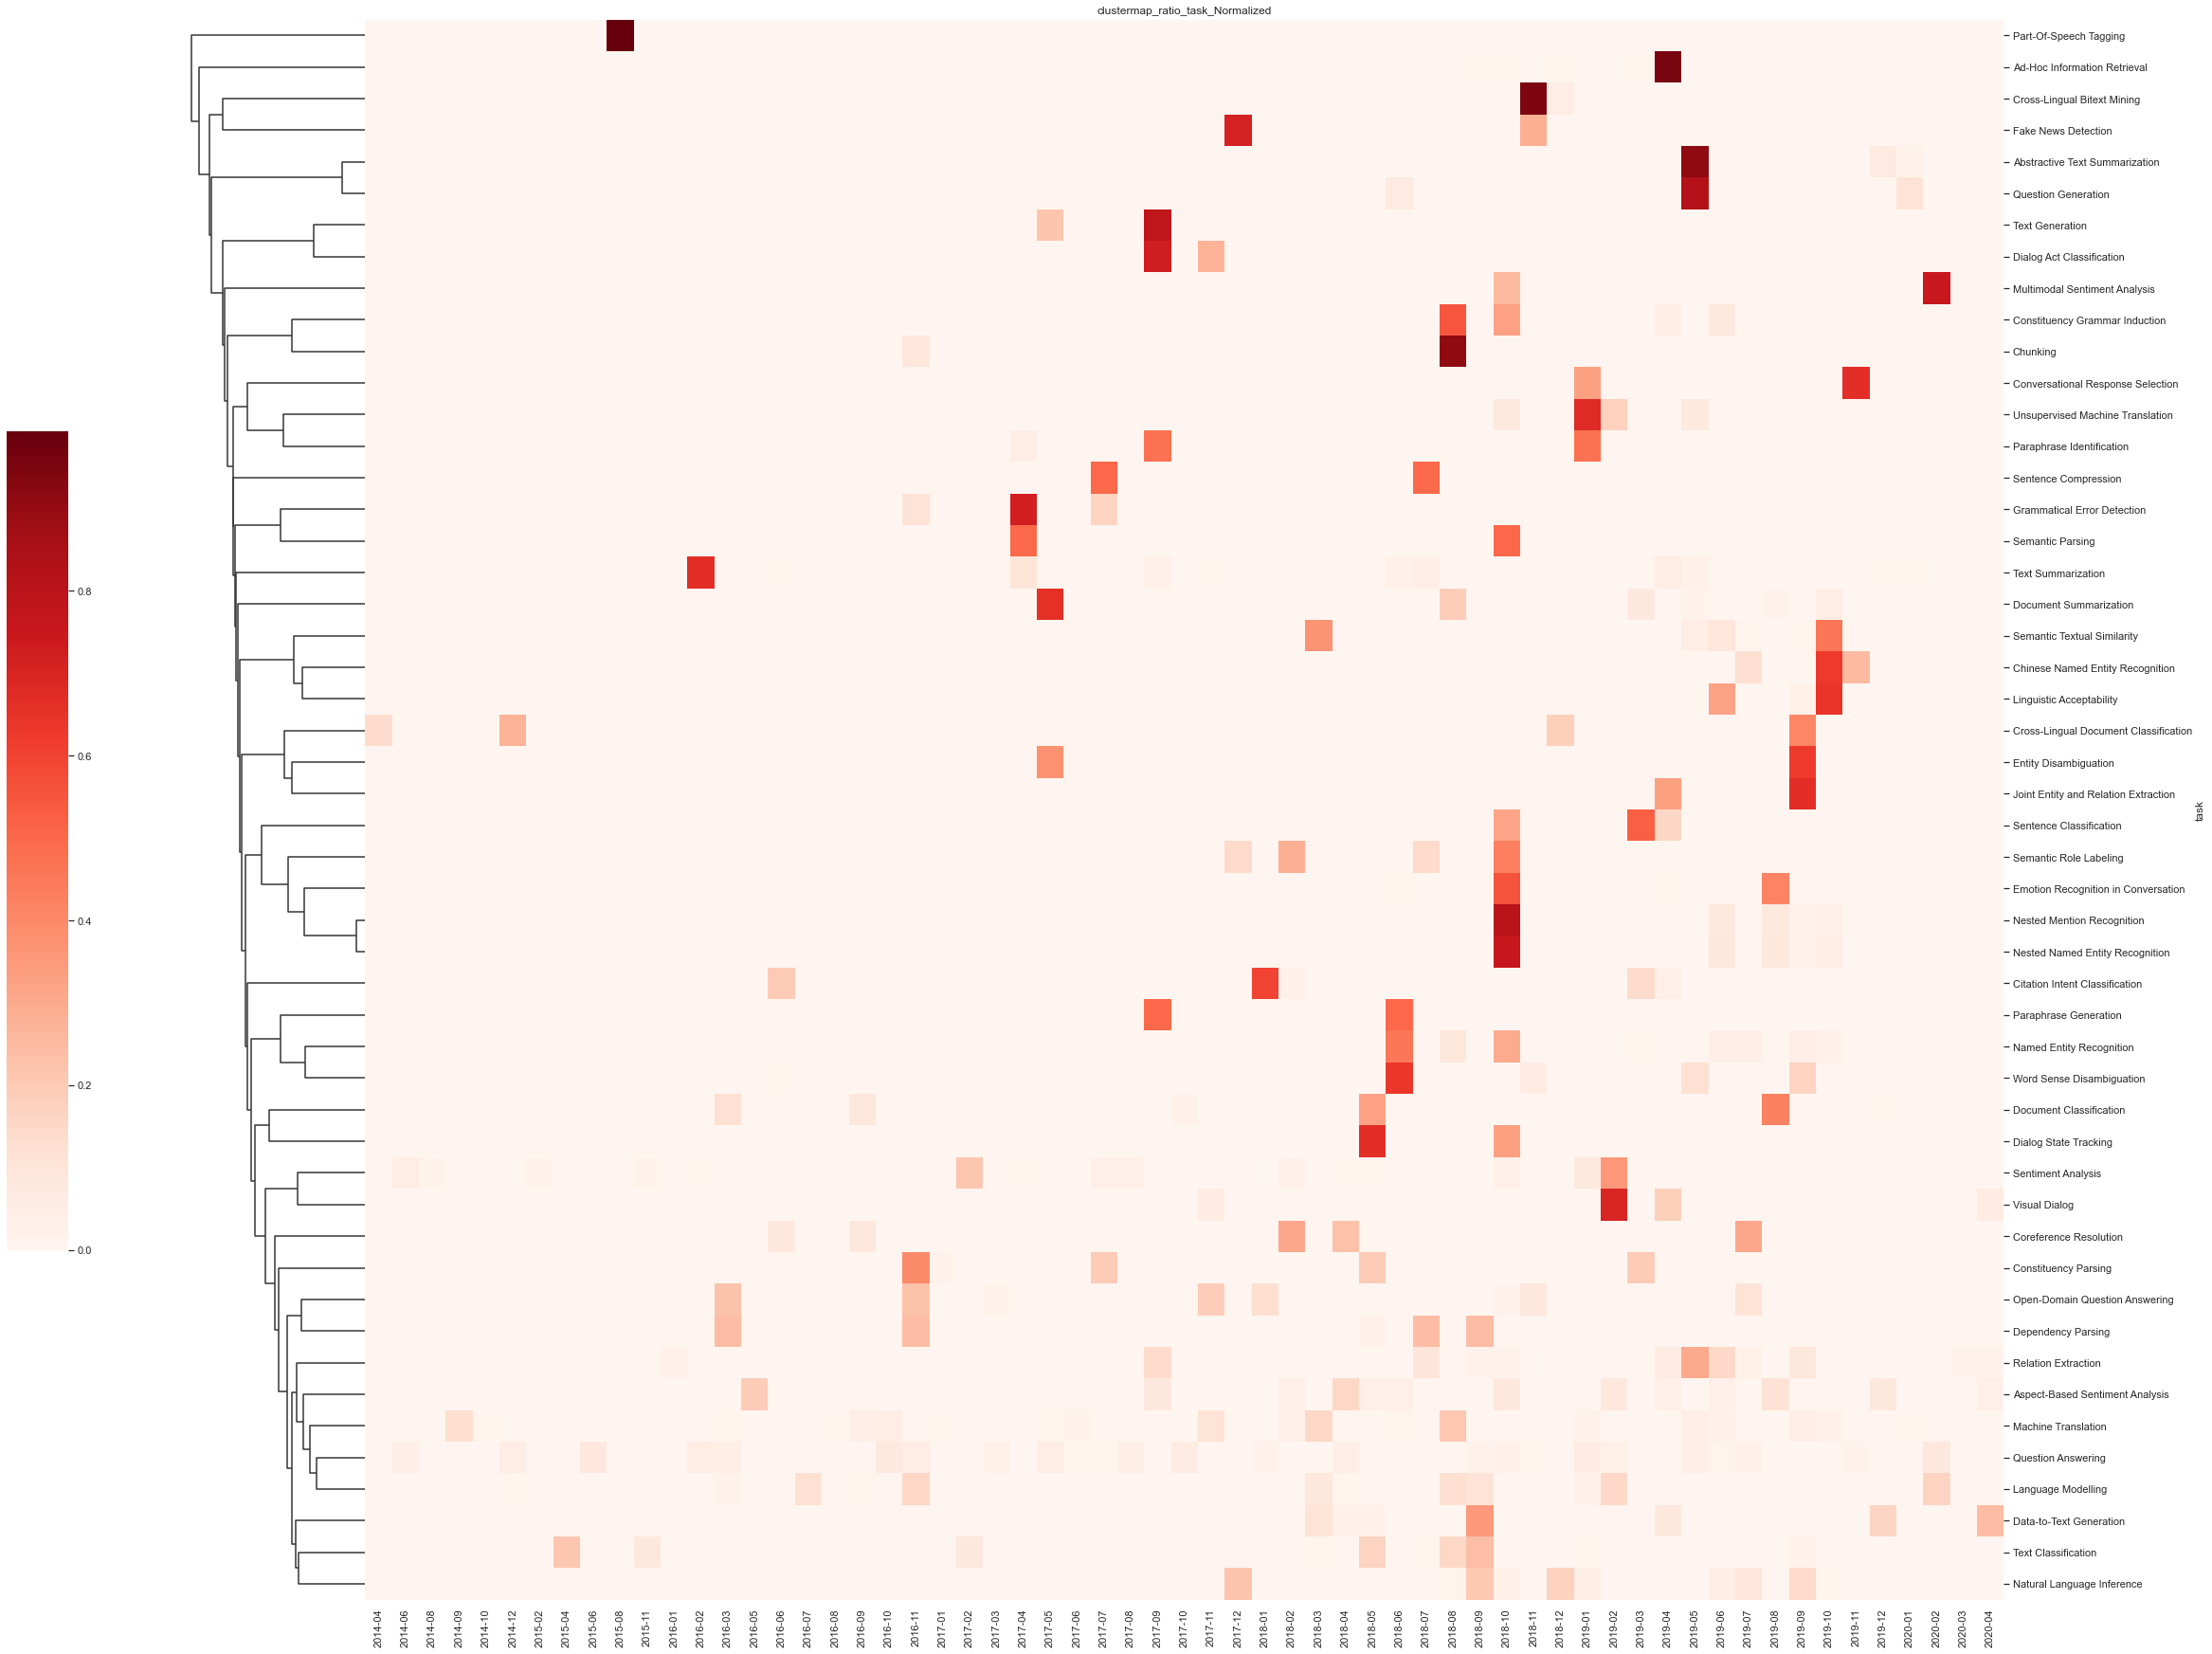

In [57]:
sns.set(font_scale=1)
res2 = sns.clustermap(
    df,
    figsize=(30, 30),
    metric="euclidean",
    cmap="Reds",
    # row_cluster=False,
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(-0.08, 0.2, 0.03, 0.4),
    tree_kws=dict(linewidths=1.5)
)
res2.ax_col_dendrogram.set_visible(False)
res2.ax_heatmap.set_title('clustermap_ratio_task_Normalized')
res2.savefig("./PLOT_4_plots/clustermap_ratio_task_Normalized.png")

In [58]:
#reorder: extract the order of the clustered table
reordered_df2 = extract_clustered_table(res2, df)

#create copy and reorder
average_summary_IN4 = pd.DataFrame(columns=average_summary_IN3.columns)

for task in reordered_df2.index.values:
    row = average_summary_IN3[average_summary_IN3.task == task]
    average_summary_IN4 = average_summary_IN4.append(row, ignore_index=True)
#    average_summary_IN2 = average_summary_IN2.append(row)

#This is now the normalized and re-ordered dataframe
average_summary_IN4

,task,date,ratio,in_trajectory
0,Part-Of-Speech Tagging,2015-08,0.993915,IN
1,Part-Of-Speech Tagging,2017-11,0.002028,IN
2,Part-Of-Speech Tagging,2018-05,0.002028,IN
3,Part-Of-Speech Tagging,2019-08,0.002028,IN
4,Ad-Hoc Information Retrieval,2018-09,0.009615,IN
...,...,...,...,...
325,Natural Language Inference,2019-06,0.044031,IN
326,Natural Language Inference,2019-07,0.092955,IN
327,Natural Language Inference,2019-09,0.141879,IN
328,Natural Language Inference,2019-10,0.009785,IN


In [59]:
fig_traj_norm_reord = px.line(average_summary_IN4, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj_norm_reord.add_trace(
    go.Scatter(
        x=average_summary_IN3["date"],
        y=average_summary_IN3["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN3["task"]
        + "<BR>task: "
        + average_summary_IN3["task"]
        + "<BR>date: "
        + average_summary_IN3["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN3["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN3["ratio"],  # set color equal to a variable
            colorscale="Reds",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj_norm_reord.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj_norm_reord.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj_norm_reord.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj_norm_reord.update_layout(
    title="Trajectory for ratio (task per year) - Normalized",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj_norm_reord.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj_norm_reord, "./PLOT_4_plots/fig_traj_norm_reord.png")